# KuaiRec 2.0 Recommender System

This repository implements a two-stage recommender system pipeline for the KuaiRec 2.0 dataset, comparing a baseline collaborative filtering model with a hybrid model that incorporates side features.




In [3]:
%pip install pandas numpy matplotlib tqdm lightfm


  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached numpy-2.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached lightfm-1.17-cp310-cp310-linux_x86_64.whl
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pillow-11.2.1-cp310-cp310-manylinux_2_28_x86_64.whl (4.6 MB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.58.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.

In [12]:
# Import standard libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import lightfm
import os

# Import local modules
from loaddata import load_interaction_data, load_item_categories, load_user_features, print_dataset_info
from preprocess import (
    derive_implicit_labels, filter_interactions, create_user_item_maps,
    leave_n_out_split, prepare_item_features, prepare_user_features
)
from evaluation import evaluate_model, plot_learning_curves
from main import train_baseline_model, train_hybrid_model, run_pipeline

# Constants
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set up data directory
SCRIPT_DIR = Path(os.path.dirname(os.path.abspath("__file__")))
DATA_DIR = SCRIPT_DIR / "KuaiRec2.0" / "data"

print("Run good")


Run good


## Data Loading and Preprocessing

Let's start by loading the KuaiRec 2.0 dataset and examining its structure.

In [14]:
# Define file paths
matrix_file = "small_matrix.csv"  # Update with actual filename
item_categories_file = "item_categories.csv"  # Update with actual filename
user_features_file = "user_features.csv"  # Update with actual filename

# Check if files exist
matrix_path = DATA_DIR / matrix_file
item_categories_path = DATA_DIR / item_categories_file
user_features_path = DATA_DIR / user_features_file

file_check = {
    "Interaction data": matrix_path.exists(),
    "Item categories": item_categories_path.exists(),
    "User features": user_features_path.exists()
}
print("File availability:")
for name, exists in file_check.items():
    print(f"  {name}: {'✓' if exists else '✗'} ({name} {'exists' if exists else 'not found'})")


File availability:
  Interaction data: ✓ (Interaction data exists)
  Item categories: ✓ (Item categories exists)
  User features: ✓ (User features exists)


In [15]:
# Load data if files exist
if all(file_check.values()):
    print(f"Loading data from {matrix_file}...")
    interactions_df = load_interaction_data(matrix_path)
    
    print(f"Loading item categories...")
    item_categories_df = load_item_categories(item_categories_path)
    
    print(f"Loading user features...")
    user_features_df = load_user_features(user_features_path)
    
    # Display basic information about the datasets
    print_dataset_info(interactions_df, "Interaction Data")
    print_dataset_info(item_categories_df, "Item Categories")
    print_dataset_info(user_features_df, "User Features")


Loading data from small_matrix.csv...
Loading item categories...
Loading user features...

--------------------------------------------------
Dataset: Interaction Data
--------------------------------------------------
Shape: (4676570, 8) (4676570 rows, 8 columns)

Columns: user_id, video_id, play_duration, video_duration, time, date, timestamp, watch_ratio

Sample data:
   user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   

         date     timestamp  watch_ratio  
0  20200705.0  1.593898e+09     0.722103  
1  20200705.0  1.593898e+09     1.907377  
2  20200705.0  1

## Data Preprocessing

Now we'll prepare the data for training by deriving implicit labels, filtering interactions, and creating train-test splits.

In [16]:
# Process data if loaded successfully
if 'interactions_df' in locals():
    # Derive implicit labels
    print("\nDeriving implicit labels (watch_ratio >= 0.8)...")
    interactions_df = derive_implicit_labels(interactions_df)
    positive_ratio = interactions_df['label'].mean()
    print(f"Positive interactions ratio: {positive_ratio:.4f}")
    
    # Filter users and items
    print("\nFiltering users and items with >= 3 positive interactions...")
    filtered_df, valid_users, valid_items = filter_interactions(interactions_df)
    
    # Create ID mappings
    user_to_idx, idx_to_user, item_to_idx, idx_to_item = create_user_item_maps(valid_users, valid_items)
    
    # Split data into train and test sets
    print("\nSplitting data (leave-n-out)...")
    split_data = leave_n_out_split(
        filtered_df, 
        user_to_idx, 
        item_to_idx, 
        test_ratio=0.2, 
        neg_ratio=4, 
        test_neg_ratio=99, 
        random_state=RANDOM_SEED
    )



Deriving implicit labels (watch_ratio >= 0.8)...
Positive interactions ratio: 0.4744

Filtering users and items with >= 3 positive interactions...
Counting positive interactions per user and item...
Applying filtering...
Original interactions: 4676570
Filtered interactions: 4621597
Unique users: 1411
Unique items: 3288
Creating user and item mappings...

Splitting data (leave-n-out)...
Building user interaction dictionaries...


Processing interactions: 100%|██████████| 4621597/4621597 [03:10<00:00, 24285.11it/s]


Creating train-test split...


Splitting users: 100%|██████████| 1411/1411 [00:12<00:00, 116.53it/s]


Creating DataFrames and matrices...
Building sparse matrices...
Training interactions: 1792126
Testing interactions: 44114603


## Model Training

We'll train both a baseline collaborative filtering model and a hybrid model that incorporates side features.

In [17]:
# Train baseline model if data is prepared
if 'split_data' in locals():
    # Set training parameters
    epochs = 50  # Reduced for notebook demonstration
    eval_every = 5
    
    # Train baseline model
    baseline_model, baseline_train_metrics, baseline_test_metrics, baseline_epochs, baseline_time = train_baseline_model(
        split_data, 
        split_data, 
        epochs=epochs, 
        eval_every=eval_every
    )



Training Baseline Model (LightFM with BPR loss)


Evaluating at epoch 5:   8%|▊         | 4/50 [00:04<00:44,  1.03it/s]  

Evaluating model on multiple metrics...





























































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Evaluating model on multiple metrics...


























































































































































































































































































































































































































Evaluating at epoch 10:  18%|█▊        | 9/50 [01:08<03:42,  5.42s/it, train_f1@5=0.0083, test_f1@5=0.0314]

Evaluating model on multiple metrics...



























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Evaluating model on multiple metrics...






















































































































































































































































































































































































































Evaluating at epoch 15:  28%|██▊       | 14/50 [02:07<03:23,  5.65s/it, train_f1@5=0.0083, test_f1@5=0.0314]

Evaluating model on multiple metrics...



























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Evaluating model on multiple metrics...

























































































































































































































































































































































































































Evaluating at epoch 20:  38%|███▊      | 19/50 [03:07<02:55,  5.66s/it, train_f1@5=0.0083, test_f1@5=0.0311]

Evaluating model on multiple metrics...



























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Evaluating model on multiple metrics...



























































































































































































































































































































































































































Evaluating at epoch 25:  48%|████▊     | 24/50 [04:07<02:29,  5.74s/it, train_f1@5=0.0083, test_f1@5=0.0310]

Evaluating model on multiple metrics...

























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Evaluating model on multiple metrics...






















































































































































































































































































































































































































Evaluating at epoch 30:  58%|█████▊    | 29/50 [05:06<01:59,  5.67s/it, train_f1@5=0.0083, test_f1@5=0.0310]

Evaluating model on multiple metrics...
























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Evaluating model on multiple metrics...






















































































































































































































































































































































































































Evaluating at epoch 35:  68%|██████▊   | 34/50 [06:05<01:29,  5.62s/it, train_f1@5=0.0083, test_f1@5=0.0308]

Evaluating model on multiple metrics...

























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Evaluating model on multiple metrics...

























































































































































































































































































































































































































Evaluating at epoch 40:  78%|███████▊  | 39/50 [07:04<01:01,  5.63s/it, train_f1@5=0.0083, test_f1@5=0.0309]

Evaluating model on multiple metrics...


























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Evaluating model on multiple metrics...



























































































































































































































































































































































































































Evaluating at epoch 45:  88%|████████▊ | 44/50 [08:05<00:35,  5.92s/it, train_f1@5=0.0083, test_f1@5=0.0309]

Evaluating model on multiple metrics...


































































Computing metrics: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Evaluating model on multiple metrics...






























































































































































































































































































































































































































Evaluating at epoch 50:  98%|█████████▊| 49/50 [09:07<00:05,  5.95s/it, train_f1@5=0.0083, test_f1@5=0.0308]

Evaluating model on multiple metrics...



























































Computing metrics: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Evaluating model on multiple metrics...






























































































































































































































































































































































































































Evaluating at epoch 50: 100%|██████████| 50/50 [10:03<00:00, 12.08s/it, train_f1@5=0.0083, test_f1@5=0.0309]



Total training time: 603.78 seconds

Final metrics:
  Train: {'precision@5': np.float64(0.9998582565556343), 'recall@5': np.float64(0.004189601854814025), 'f1@5': np.float64(0.008342059641653148), 'recall@10': np.float64(0.008376678863287806), 'ndcg@10': np.float64(0.9996893785300669)}
  Test:  {'precision@5': np.float64(0.939900779588944), 'recall@5': np.float64(0.015706892719734654), 'f1@5': np.float64(0.030865970154563195), 'recall@10': np.float64(0.02971192471193606), 'ndcg@10': np.float64(0.9116294592767561)}


In [18]:
# Prepare item and user features and train hybrid model
if 'split_data' in locals() and 'item_categories_df' in locals() and 'user_features_df' in locals():
    print("\nPreparing item and user features...")
    item_features_mat = prepare_item_features(item_categories_df, item_to_idx)
    user_features_mat = prepare_user_features(user_features_df, user_to_idx)
    
    # Train hybrid model
    hybrid_model, hybrid_train_metrics, hybrid_test_metrics, hybrid_epochs, hybrid_time = train_hybrid_model(
        split_data, 
        split_data, 
        user_features_mat,
        item_features_mat,
        epochs=epochs, 
        eval_every=eval_every
    )



Preparing item and user features...
Preparing item features...
Extracting categories...


Processing categories: 100%|██████████| 3288/3288 [00:00<00:00, 159376.77it/s]


Building item feature matrix...


Processing items: 100%|██████████| 3288/3288 [00:00<00:00, 17227.61it/s]


Preparing user features...
Creating feature mappings...
Building user feature matrix...


Processing users: 100%|██████████| 1411/1411 [00:00<00:00, 13545.47it/s]



Training Hybrid Model (LightFM with user and item features)


Evaluating at epoch 5:   8%|▊         | 4/50 [00:34<05:18,  6.92s/it]

Evaluating model on multiple metrics...




















































































Computing metrics: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Evaluating model on multiple metrics...















































































































































































































































































































































































































































































































































































Evaluating at epoch 10:  18%|█▊        | 9/50 [02:28<08:44, 12.78s/it, train_f1@5=0.0082, test_f1@5=0.0279]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Evaluating model on multiple metrics...































































































































































































































































































































































































































































































































































Evaluating at epoch 15:  28%|██▊       | 14/50 [04:13<07:44, 12.90s/it, train_f1@5=0.0083, test_f1@5=0.0284]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Evaluating model on multiple metrics...

































































































































































































































































































































































































































































































































































Evaluating at epoch 20:  38%|███▊      | 19/50 [05:58<06:39, 12.90s/it, train_f1@5=0.0082, test_f1@5=0.0280]

Evaluating model on multiple metrics...


















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Evaluating model on multiple metrics...















































































































































































































































































































































































































































































































































































Evaluating at epoch 25:  48%|████▊     | 24/50 [07:45<05:40, 13.08s/it, train_f1@5=0.0083, test_f1@5=0.0287]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Evaluating model on multiple metrics...











































































































































































































































































































































































































































































































































































Evaluating at epoch 30:  58%|█████▊    | 29/50 [09:32<04:34, 13.07s/it, train_f1@5=0.0083, test_f1@5=0.0286]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Evaluating model on multiple metrics...

















































































































































































































































































































































































































































































































































































Evaluating at epoch 35:  68%|██████▊   | 34/50 [11:19<03:29, 13.12s/it, train_f1@5=0.0082, test_f1@5=0.0277]

Evaluating model on multiple metrics...






















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Evaluating model on multiple metrics...




















































































































































































































































































































































































































































































































































































Evaluating at epoch 40:  78%|███████▊  | 39/50 [13:08<02:25, 13.25s/it, train_f1@5=0.0083, test_f1@5=0.0281]

Evaluating model on multiple metrics...





















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Evaluating model on multiple metrics...








































































































































































































































































































































































































































































































































































Evaluating at epoch 45:  88%|████████▊ | 44/50 [14:55<01:18, 13.11s/it, train_f1@5=0.0082, test_f1@5=0.0273]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Evaluating model on multiple metrics...

































































































































































































































































































































































































































































































































































Evaluating at epoch 50:  98%|█████████▊| 49/50 [16:39<00:12, 12.93s/it, train_f1@5=0.0083, test_f1@5=0.0282]

Evaluating model on multiple metrics...
















































































Computing metrics: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Evaluating model on multiple metrics...









































































































































































































































































































































































































































































































































































Evaluating at epoch 50: 100%|██████████| 50/50 [17:51<00:00, 21.44s/it, train_f1@5=0.0083, test_f1@5=0.0278]


Total training time: 1071.94 seconds

Final metrics:
  Train: {'precision@5': np.float64(0.9907866761162296), 'recall@5': np.float64(0.004149431487116123), 'f1@5': np.float64(0.008262093045099051), 'recall@10': np.float64(0.008313893389332586), 'ndcg@10': np.float64(0.9926846184655791)}
  Test:  {'precision@5': np.float64(0.8555634301913537), 'recall@5': np.float64(0.014127544849364664), 'f1@5': np.float64(0.027769707741811513), 'recall@10': np.float64(0.02405737810530259), 'ndcg@10': np.float64(0.7868052999830866)}


## Results Visualization

Let's visualize the learning curves and compare the performance of the baseline and hybrid models.

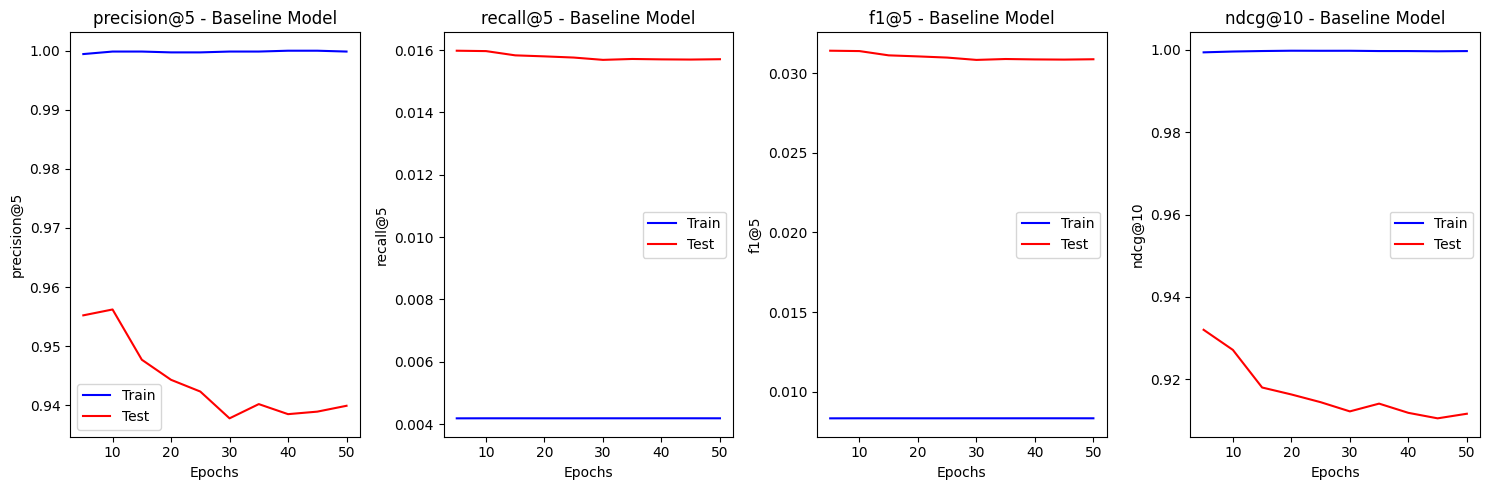

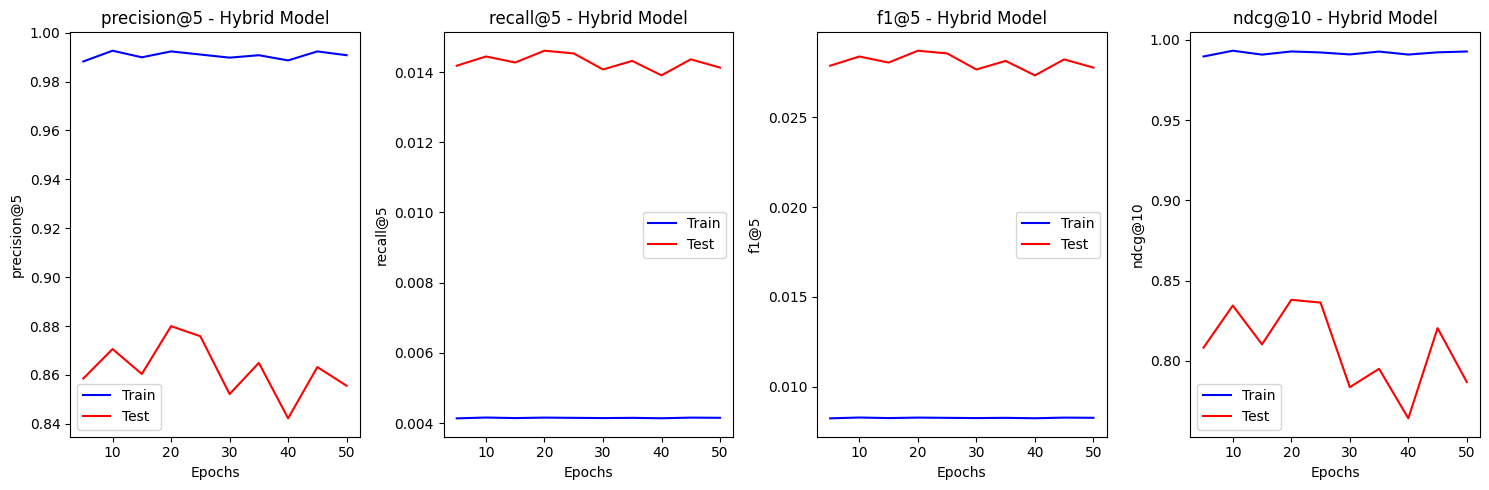


Model Comparison:
             Baseline    Hybrid  Improvement
precision@5  0.939901  0.855563    -8.973006
recall@5     0.015707  0.014128   -10.055126
f1@5         0.030866  0.027770   -10.031314
ndcg@10      0.911629  0.786805   -13.692423


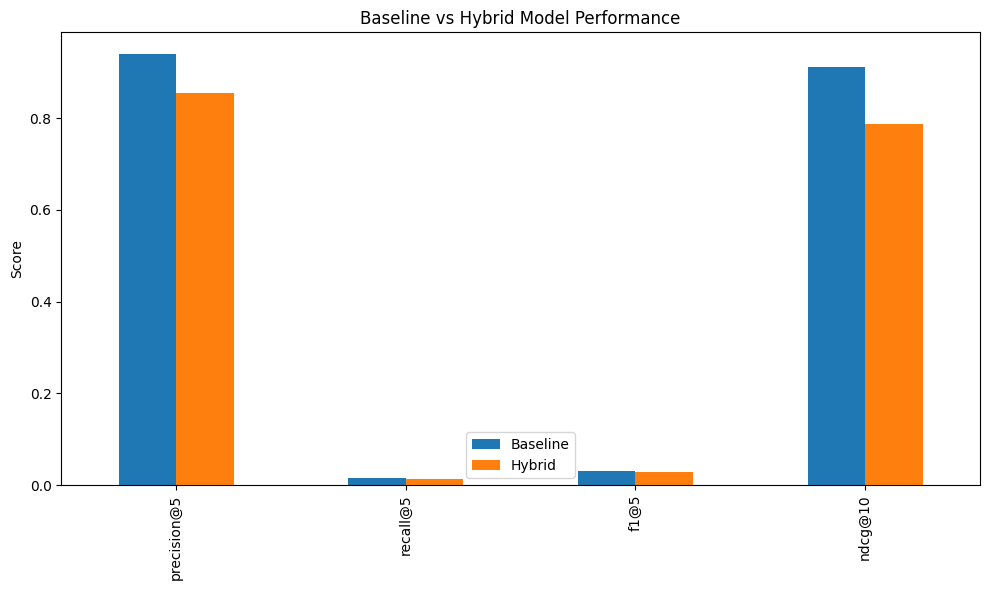

In [21]:
# Plot learning curves if both models were trained
if 'baseline_model' in locals() and 'hybrid_model' in locals():
    metrics_to_plot = ['precision@5', 'recall@5', 'f1@5', 'ndcg@10']
    
    # Plot baseline model learning curves
    plot_learning_curves(
        baseline_train_metrics, 
        baseline_test_metrics, 
        metrics_to_plot, 
        baseline_epochs, 
        "Baseline Model"
    )
    
    # Plot hybrid model learning curves
    plot_learning_curves(
        hybrid_train_metrics, 
        hybrid_test_metrics, 
        metrics_to_plot, 
        hybrid_epochs, 
        "Hybrid Model"
    )
    
    # Compare final metrics
    baseline_final = baseline_test_metrics[-1]
    hybrid_final = hybrid_test_metrics[-1]
    
    comparison = pd.DataFrame({
        'Baseline': [baseline_final[m] for m in metrics_to_plot],
        'Hybrid': [hybrid_final[m] for m in metrics_to_plot],
        'Improvement': [(hybrid_final[m] - baseline_final[m]) / baseline_final[m] * 100 for m in metrics_to_plot]
    }, index=metrics_to_plot)
    
    print("\nModel Comparison:")
    print(comparison)
    
    # Visualize comparison
    ax = comparison[['Baseline', 'Hybrid']].plot(kind='bar', figsize=(10, 6))
    ax.set_ylabel('Score')
    ax.set_title('Baseline vs Hybrid Model Performance')
    ax.legend()
    plt.tight_layout()
    plt.show()
